In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, 

### Load Raw MNIST Data distributed with Keras 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print('Total Number of Images in train set: {} with image size {} x {}'.format(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('Total Number of Images in test set: {} with image size {} x {}'.format(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

Total Number of Images in train set: 60000 with image size 28 x 28
Total Number of Images in test set: 10000 with image size 28 x 28


### Normalization
##### Rescale images from [0, 255] to [0.0, 1.0] 

In [4]:
x_train, x_test = x_train/ 255.0, x_test/255.0

#### Let's visualize the class distribution in the training set 

Text(0, 0.5, 'Number of samples')

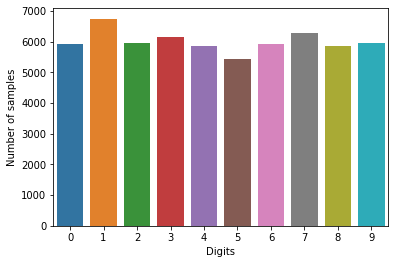

In [5]:
x, y = np.unique(y_train, return_counts = True)
sns.barplot(x =x, y = y)
plt.xlabel('Digits')
plt.ylabel('Number of samples')

As we can see that the classes are almost evenly distributed, we don't need to perform any resampling

#### Let look at the first example

This is a number 5


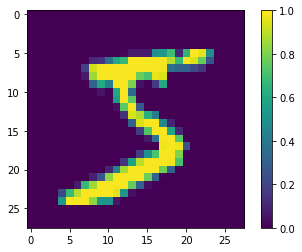

In [6]:
print('This is a number '+str(y_train[0]))
plt.imshow(x_train[0])
plt.colorbar()

#### Add Channel to images 

since the given images are in gray scale, we will add channel 1 to images


In [7]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

#### Encoding Labels

In [8]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes=num_classes)

In [9]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

#### Create Validation Set

We will create a validation set by spliting up train set into two sets. 90% in train set will use to train our model and the remaining 10% will be used to validate our model. 

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 32)

### Build our model 

#### In this project, we will use Convolutional Neural Network (CNN) from Keras

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [11]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding ='same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding ='same', activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding ='same', activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding ='same', activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Set optimizer 

We have chosen adam as the optimizer in this model as it is one of the most effective optimizer

In [12]:
optimizer = adam(lr=0.001, decay=0.0)

In [13]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#### Adjust Learning Rate

Using an annealing method of the learning rate, the optimizer can discover the global minimum of the loss function faster. 

As the learning rate is high, the bigger are the steps and quicker is the convergence. However, it will result in loss getting worse as it may bounce around. 

When the learning rate is too low, it means having to do a lot of steps which will take a long time to train the model. 

In order to keep the advantage of fast computation time with high learning rate, I decreased the LR by half if the accuary is not improved after 3 epochs 

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
epochs = 30
batch_size = 86

#### Data Augmentation

Performing data augmentation could introduce variations that we might encounter in the test set. (To prevent overfitting) 
- Rescale: rescale images to range (0.0, 1.0) PERFROMED ABOVE
- Rotation: rotates images for up to +/- 20 degree randomly
- Zoom: randomly zooms into images for up to 20% 
- Height shift: shifts the height of images by +/- 10%
- Width shift: shifts the width of images by +/- 10%

In [16]:
data_augment = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 20,
    zoom_range = .2,
    height_shift_range = .1,
    width_shift_range = .1,
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images


In [17]:
data_augment.fit(x_train)

### Train Model

In [18]:
history = model.fit(data_augment.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
627/627 [==============================] - 290s 462ms/step - loss: 0.4246 - acc: 0.8635 - val_loss: 0.0686 - val_acc: 0.9790
Epoch 2/30
627/627 [==============================] - 241s 384ms/step - loss: 0.1452 - acc: 0.9560 - val_loss: 0.0468 - val_acc: 0.9855
Epoch 3/30
627/627 [==============================] - 244s 389ms/step - loss: 0.1052 - acc: 0.9680 - val_loss: 0.0389 - val_acc: 0.9903
Epoch 4/30
627/627 [==============================] - 279s 445ms/step - loss: 0.0911 - acc: 0.9723 - val_loss: 0.0350 - val_acc: 0.9907
Epoch 5/30
627/627 [==============================] - 310s 494ms/step - loss: 0.0809 - acc: 0.9760 - val_loss: 0.0355 - val_acc: 0.9908
Epoch 6/30
627/627 [==============================] - 331s 528ms/step - loss: 0.0748 - acc: 0.9782 - val_loss: 0.0304 - val_acc: 0.9923
Epoch 7/30
627/627 [==============================] - 304s 484ms/step - loss: 0.0696 - acc

### Model Evaluation

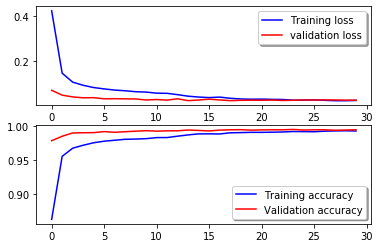

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The model reachs 99+% accuarcy. Since the validation accuracy is greater than the training accuracy, no overfitting has appeared in the model. 